#**GRU TRAINING PHASE**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
data = pd.read_csv('sorted_energy_data.csv', parse_dates=['Datetime'], index_col='Datetime')
data = data.sort_index()  # Ensure the data is sorted by datetime
print(data.head(10))  # Display first 10 rows to check data
df = data



                      NI_MW
Datetime                   
2004-05-01 01:00:00  9198.0
2004-05-01 02:00:00  8570.0
2004-05-01 03:00:00  8183.0
2004-05-01 04:00:00  7917.0
2004-05-01 05:00:00  7828.0
2004-05-01 06:00:00  7806.0
2004-05-01 07:00:00  8082.0
2004-05-01 08:00:00  8267.0
2004-05-01 09:00:00  8830.0
2004-05-01 10:00:00  9381.0


##**pre-processing steps**

In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing

# Normalize Data (Min-Max Scaling)
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['NI_MW'] = scaler.fit_transform(df['NI_MW'].values.reshape(-1, 1))
    return df, scaler

df_norm, scaler = normalize_data(df)  # Normalize the dataset

# Function to create sequences for GRU
def load_data(stock, seq_len):
    X_data = []
    y_data = []
    for i in range(seq_len, len(stock)):
        X_data.append(stock.iloc[i-seq_len:i, 0].values)  # Creating sequences for X
        y_data.append(stock.iloc[i, 0])  # Corresponding y values

    # Convert lists to numpy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

# Calculate the index for the 80% split
train_size = int(len(df_norm) * 0.8)
test_size = len(df_norm) - train_size

# Split the data into training and test sets (80% training, 20% testing)
train_data = df_norm.iloc[:train_size]
test_data = df_norm.iloc[train_size:]

# Create sequences for training and testing
seq_len = 72  # Sequence length for GRU
X_train, y_train = load_data(train_data, seq_len)
X_test, y_test = load_data(test_data, seq_len)

# Create a validation set by splitting the training data (e.g., 80% for training, 20% for validation)
val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[-val_size:], y_train[-val_size:]
X_train, y_train = X_train[:-val_size], y_train[:-val_size]

# Reshape data to be used by GRU (samples, time_steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print('X_train.shape = ', X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_val.shape = ', X_val.shape)
print('y_val.shape = ', y_val.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ', y_test.shape)


X_train.shape =  (37351, 72, 1)
y_train.shape =  (37351,)
X_val.shape =  (9337, 72, 1)
y_val.shape =  (9337,)
X_test.shape =  (11618, 72, 1)
y_test.shape =  (11618,)


###**Gated Recurrent Units**


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import SGD

# Define the GRU model
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

regressorGRU.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 72, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 72, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 72, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 72, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 72, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 72, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,901 (210.55 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import SGD

# Compile the model
regressorGRU.compile(
    optimizer=SGD(learning_rate=0.01, weight_decay=1e-7, momentum=0.9, nesterov=False),
    loss='mean_squared_error'
)# Evaluate the model on training and testing data
train_score = regressorGRU.evaluate(X_train, y_train, verbose=0)
test_score = regressorGRU.evaluate(X_test, y_test, verbose=0)

# Print MSE for both train and test sets
print(f'Train MSE: {train_score}, Test MSE: {test_score}')

# Make predictions
GRU_predictions = regressorGRU.predict(X_test)

# Inverse scale predictions (if you have scaled the data)
GRU_predictions_rescaled = scaler.inverse_transform(GRU_predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_actual_rescaled, GRU_predictions_rescaled))
print(f'RMSE: {rmse}')


# Fit the model
regressorGRU.fit(X_train, y_train, epochs=10, batch_size=64)

Epoch 1/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 0.0171
Epoch 2/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - loss: 0.0091
Epoch 3/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0065
Epoch 4/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0052
Epoch 5/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0043
Epoch 6/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0036
Epoch 7/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0031
Epoch 8/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 0.0028
Epoch 9/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0026
Epoch 10/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0025


In [ ]:
regressorGRU.save("GRU-model.h5")

In [ ]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
# Evaluate the model on training and testing data
train_score = regressorGRU.evaluate(X_train, y_train, verbose=0)
test_score = regressorGRU.evaluate(X_test, y_test, verbose=0)

# Print MSE for both train and test sets
print(f'Train MSE: {train_score}, Test MSE: {test_score}')

# Make predictions
GRU_predictions = regressorGRU.predict(X_test)

# Inverse scale predictions (if you have scaled the data)
GRU_predictions_rescaled = scaler.inverse_transform(GRU_predictions)
y_test_actual_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE
rmse = math.sqrt(mean_squared_error(y_test_actual_rescaled, GRU_predictions_rescaled))
print(f'RMSE: {rmse}')


Train MSE: 0.0016094946768134832, Test MSE: 0.0014391737058758736
364/364 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
RMSE: 630.807059901452


364/364 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


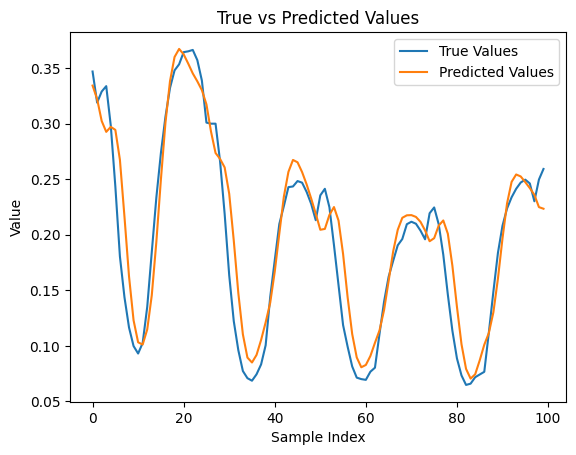

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred is the predictions made by the model
y_pred = regressorGRU.predict(X_test)

# Plot predictions vs true values for the test set
plt.plot(y_test[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()


WITH HYPERPARAMETER TUNING

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

# Load the saved model
best_gru_model = load_model("/content/GRU-model.h5")

# Recreate the optimizer (e.g., Adam)
optimizer = Adam()

# Recompile the model with the correct loss function and metrics
best_gru_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Assuming you have your training data loaded as X_train and y_train
# Continue training for 10 more epochs
best_gru_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 207s 171ms/step - accuracy: 1.5216e-04 - loss: 0.0015
Epoch 2/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 202s 171ms/step - accuracy: 7.0689e-05 - loss: 6.5264e-04
Epoch 3/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 202s 173ms/step - accuracy: 5.7990e-05 - loss: 5.7047e-04
Epoch 4/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 198s 170ms/step - accuracy: 1.3734e-04 - loss: 5.5869e-04
Epoch 5/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 203s 171ms/step - accuracy: 3.0016e-05 - loss: 5.0100e-04
Epoch 6/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 208s 176ms/step - accuracy: 1.0601e-04 - loss: 5.0240e-04
Epoch 7/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 199s 171ms/step - accuracy: 1.0307e-04 - loss: 4.8713e-04
Epoch 8/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 198s 169ms/step - accuracy: 7.2025e-05 - loss: 4.7361e-04
Epoch 9/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 204s 175ms/step - accuracy: 3.4768e-05 - loss: 4.5237e-04
Epoch 10/10
1168/1168 ━━━━━━━━━━━━━━━━━━━━ 199s 170ms/step - accuracy: 5.8405e-05 - loss: 4.4746e-04


In [ ]:
best_gru_model.save("new_gru_model.h5")

#After 20 epochs

364/364 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step


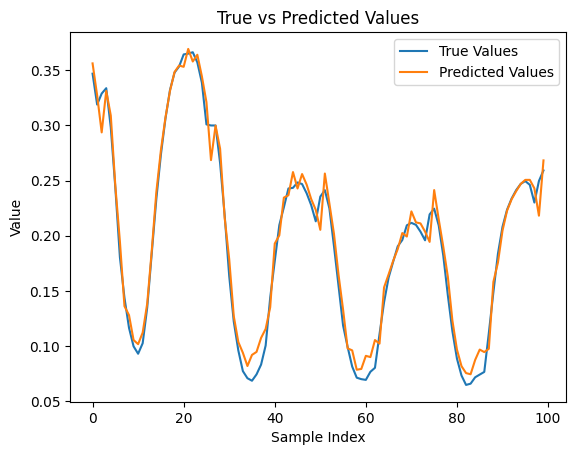

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming y_pred is the predictions made by the model
y_pred = best_gru_model.predict(X_test)

# Plot predictions vs true values for the test set
plt.plot(y_test[:100], label='True Values')
plt.plot(y_pred[:100], label='Predicted Values')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()
